# Guide to producing figures

In this notebook we will discuss how the main figures for the standard problem are produced. As noted in the [README](README.md), these can also be produced by running `make figures` in the source directories. This is an alternative, annotated description of the analysis to help users understand the important steps. For all figures here we will use the cached **OOMMF** data.

## Required tools

Firstly we import all required tools, if you recieve an `ImportError` after running the following cell then you may not have `matplotlib` or `numpy` installed. We also define a function `fft`, which generates the frequency spectrum using  a fast Fourier transform (using the `numpy`, `fft` routin). 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def fft(mx, dt=5e-12):
    """ FFT of the data at dt """
    n = len(mx)
    freq = np.fft.fftfreq(n, dt)

    ft_mx = np.fft.fft(mx)

    ft_abs = np.abs(ft_mx)
    ft_phase = np.angle(ft_mx)

    return freq, ft_abs, ft_phase

## Producing Figure 2

We will be using the cached file `dynamic_txyz.txt` which contains the output on the magnetisation as a function of time for *dynamic* stage of the standard problem as produced by `OOMMF`. We begin by reading in this cached data and extracting the y component of the magnetisation. 

In [2]:
txyzFileLoc = "./src/oommf_scripts/dynamic_txyz.txt"

data = np.loadtxt(txyzFileLoc)

ts = data[:, 0]
my = data[:, 2]

Following this, we generate the frequency spectrum using the previously defined `fft` function. This returns the frequency `freq`, the absolute magnitude of amplitude `ft_abs`, and the `phase`. 

In [3]:
dt = ts[1]-ts[0]
freq, ft_abs, phase = fft(my, dt)

The following code generates Figure 2, using the data. For help with the plotting routines please refer to the [matplotlib documentation](http://matplotlib.org/).

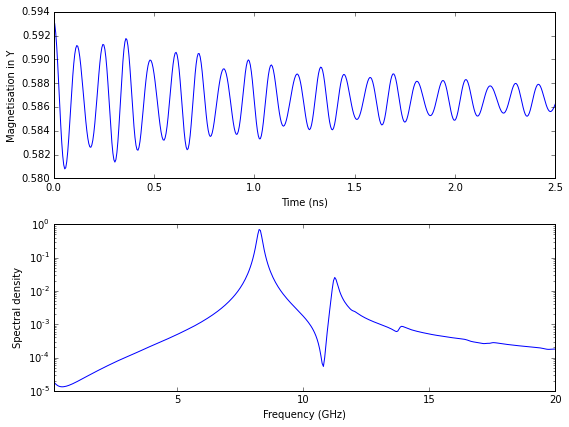

In [4]:

ft_power = ft_abs**2
length = len(freq)/2

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(ts*1e9, my, label='Real')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Magnetisation in Y')
ax.set_xlim([0, 2.5])

ax = fig.add_subplot(2, 1, 2)
ax.plot(freq[0:length]*1e-9, ft_power[0:length], '-', label='Real')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Spectral density')
ax.set_xlim([0.1, 20])
ax.set_ylim([1e-5, 1e-0])
ax.set_yscale('log')

plt.tight_layout()

## Producing Figure 3

Figure 3 compares the *spatially resolved* power spectrum, $S_{y}$, and the *spatially averaged* power spectrum, $\tilde{S}_y$, as defined in Eq. (5). To produce these figures we first generate the spatially averaged power spectrum: taking the y-magnetization data we use a function `spatial_fft` to save the data to `./src/oommf_scripts/mys_ft_abs.npy` and `./src/oommf_scripts/mys_ft_phase.npy`. Note that we produce the data for all three directions, but in the following only the `y` component is used (the others are used in generating figures (4) and (5)).

In [11]:
def spatial_fft(dataname):
    """ Spatially averaged FFT as defined in Eqn. (4) """
    ft_abs = []
    ft_phase = []

    mys = np.load(dataname)
    m, n = mys.shape

    for i in range(n):
        f, ft_a, ft_p = fft(mys[:, i])
        ft_abs.append(ft_a)
        ft_phase.append(ft_p)

    np.save(dataname[:-4]+'_ft_abs.npy', np.array(ft_abs))
    np.save(dataname[:-4]+'_ft_phase.npy', np.array(ft_phase))
    
spatial_fft("./src/oommf_scripts/mxs.npy")
spatial_fft("./src/oommf_scripts/mys.npy")
spatial_fft("./src/oommf_scripts/mzs.npy")

We now load the data: for the spatially resolved data this is the same file `./src/oommf_scripts/dynamic_txyz.txt` used in generating Figure 2, for the spatially averaged data this is the file `./src/oommf_scripts/mys_ft_abs.npy` produced in the previous cell.

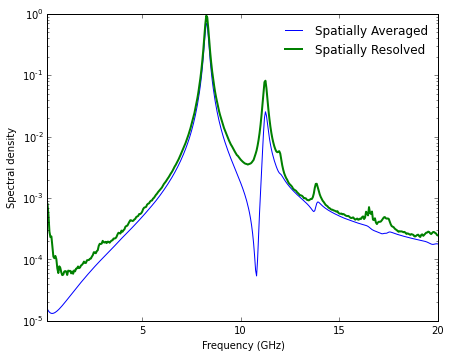

In [10]:
txyzFileLoc = "./src/oommf_scripts/dynamic_txyz.txt"
mys_ft_absLoc = "./src/oommf_scripts/mys_ft_abs.npy"
data = np.loadtxt(txyzFileLoc)

ts = data[:, 0]
my = data[:, 2]

dt = ts[1]-ts[0]

freq, ft_abs, phase = fft(my,  dt)
ft_power = ft_abs**2

length = len(freq)/2

mys = np.load(mys_ft_absLoc)
averaged = np.average(mys**2, axis=0)

fig = plt.figure(figsize=(7, 5.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(freq[0:length]*1e-9, ft_power[0:length], label='Spatially Averaged')
ax.plot(freq[0:length]*1e-9, averaged[0:length], color="g", lw=2, label='Spatially Resolved')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Spectral density')
ax.set_xlim([0.2, 20])
ax.set_ylim([1e-5, 1e0])
ax.set_yscale('log')
ax.legend(frameon=False)
plt.show()

## Producing Figure 4 and 5

For figures 4 and 5, we use data on the absolute amplitude and phase for each of the three directions.

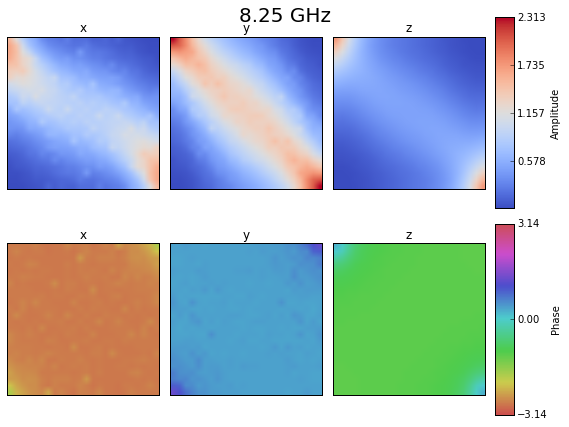

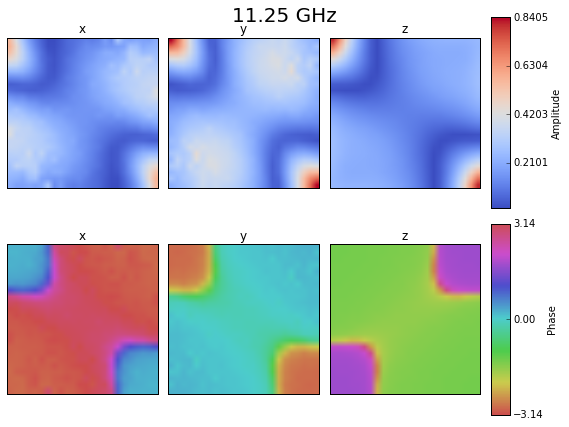

In [14]:
txyzFileLoc = "./src/oommf_scripts/dynamic_txyz.txt"
mxs_ft_absLoc = "./src/oommf_scripts/mxs_ft_abs.npy"
mys_ft_absLoc = "./src/oommf_scripts/mys_ft_abs.npy"
mzs_ft_absLoc = "./src/oommf_scripts/mzs_ft_abs.npy"
mxs_ft_phaseLoc = "./src/oommf_scripts/mxs_ft_phase.npy"
mys_ft_phaseLoc = "./src/oommf_scripts/mys_ft_phase.npy"
mzs_ft_phaseLoc = "./src/oommf_scripts/mzs_ft_phase.npy"
software = "OOMMF"

import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import cm

def find_freq_index(f, n, dt):
    freqs = np.fft.fftfreq(n, dt)

    df = freqs[1]-freqs[0]
    for i in range(n):
        if abs(f-freqs[i]) < 1e-5*df:
            return i

    raise Exception("Failed to find the index of given frequency!")

def rescale_cmap(cmap_name, low=0.0, high=1.0, plot=False):
    import matplotlib._cm as _cm
    '''
    Example 1:
    # equivalent scaling to cplot_like(blah, l_bias=0.33, int_exponent=0.0)
    my_hsv = rescale_cmap('hsv', low = 0.3)
    Example 2:
    my_hsv = rescale_cmap(cm.hsv, low = 0.3)
    '''
    if type(cmap_name) is str:
        cmap = eval('_cm._%s_data' % cmap_name)
    else:
        cmap = eval('_cm._%s_data' % cmap_name.name)
    LUTSIZE = plt.rcParams['image.lut']
    r = np.array(cmap['red'])
    g = np.array(cmap['green'])
    b = np.array(cmap['blue'])
    range = high - low
    r[:, 1:] = r[:, 1:]*range+low
    g[:, 1:] = g[:, 1:]*range+low
    b[:, 1:] = b[:, 1:]*range+low
    _my_data = {'red':   tuple(map(tuple, r)),
                'green': tuple(map(tuple, g)),
                'blue':  tuple(map(tuple, b))
                }
    my_cmap = colors.LinearSegmentedColormap('my_hsv', _my_data, LUTSIZE)

    if plot:
        print 'plotting'
        plt.figure()
        plt.plot(r[:, 0], r[:, 1], 'r', g[:, 0], g[:, 1], 'g', b[:, 0],
                 b[:, 1], 'b', lw=3)
        plt.axis(ymin=-0.2,  ymax=1.2)
        plt.show()

    return my_cmap

# Different simulation tools produce slightly different peaks:
if software.lower() == 'OOMMF'.lower():
    peaks = [8.25e9, 11.25e9, 13.9e9]
elif software.lower() == 'Nmag'.lower():
    peaks = [8.1e9, 11.0e9, 13.5e9]
else:
    raise ValueError(
        "You must specify the software used to generate the data")

data = np.loadtxt(txyzFileLoc)
ts = data[:, 0]
n = len(ts)
dt = ts[1]-ts[0]

nx = 24
ny = 24

mx_abs = np.load(mxs_ft_absLoc)
my_abs = np.load(mys_ft_absLoc)
mz_abs = np.load(mzs_ft_absLoc)

mx_phase = np.load(mxs_ft_phaseLoc)
my_phase = np.load(mys_ft_phaseLoc)
mz_phase = np.load(mzs_ft_phaseLoc)

for peak, fignum in zip(peaks, ['4', '5']):
    figname = "figure{}_{}.pdf".format(fignum, software)
    index = find_freq_index(peak, n, dt)

    peakGHz = str(round((peak * 1e-9), 4))

    amp_x = mx_abs[:, index].reshape((ny, nx))
    amp_y = my_abs[:, index].reshape((ny, nx))
    amp_z = mz_abs[:, index].reshape((ny, nx))

    phase_x = mx_phase[:, index].reshape((ny, nx))
    phase_y = my_phase[:, index].reshape((ny, nx))
    phase_z = mz_phase[:, index].reshape((ny, nx))

    # Ensure that all three amplitude plots are on the same scale:
    max_X = np.amax(amp_x)
    max_Y = np.amax(amp_y)
    max_Z = np.amax(amp_z)
    maxVal = max([max_X, max_Y, max_Z])

    min_X = np.amin(amp_x)
    min_Y = np.amin(amp_y)
    min_Z = np.amin(amp_z)
    minVal = min([min_X, min_Y, min_Z])

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 4, width_ratios=[4, 4, 4, 0.5],
                           height_ratios=[4, 4])
    plt.subplot(gs[0])
    ax = plt.gca()
    plt.imshow(amp_x, cmap=plt.cm.coolwarm, vmin=minVal, vmax=maxVal,
               origin='lower')
    plt.title('x')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(gs[1])
    ax = plt.gca()
    plt.imshow(amp_y, cmap=plt.cm.coolwarm, vmin=minVal, vmax=maxVal,
               origin='lower')
    plt.title('y')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(gs[2])
    ax = plt.gca()
    plt.imshow(amp_z, cmap=plt.cm.coolwarm, vmin=minVal, vmax=maxVal,
               origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.title('z')

    plt.subplot(gs[3])
    ax = plt.gca()
    norm = mpl.colors.Normalize(vmin=minVal, vmax=maxVal)
    cb1 = mpl.colorbar.ColorbarBase(ax, plt.cm.coolwarm, norm=norm,
                                    orientation='vertical',
                                    ticks=[0, maxVal*0.25, maxVal*0.5,
                                           maxVal*0.75, maxVal])
    cb1.set_label('Amplitude')

    my_hsv = rescale_cmap(cm.hsv, low=0.3, high=0.8, plot=False)

    plt.subplot(gs[4])
    ax = plt.gca()
    plt.imshow(phase_x, cmap=my_hsv, vmin=-np.pi, vmax=np.pi, origin='lower')
    plt.title('x')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(gs[5])
    ax = plt.gca()
    plt.imshow(phase_y, cmap=my_hsv, vmin=-np.pi, vmax=np.pi, origin='lower')
    plt.title('y')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(gs[6])
    ax = plt.gca()
    plt.imshow(phase_z, cmap=my_hsv, vmin=-np.pi, vmax=np.pi)
    plt.xticks([])
    plt.yticks([])
    plt.title('z')

    plt.subplot(gs[7])
    ax = plt.gca()

    norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
    cb1 = mpl.colorbar.ColorbarBase(ax, my_hsv, norm=norm,
                                    orientation='vertical',
                                    ticks=[-3.14, 0, 3.14])
    cb1.set_label('Phase')

    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, wspace=0.1)
    fig.suptitle('%s GHz' % peakGHz, fontsize=20)
    fig.tight_layout()